In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/training-validation'

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/training-validation.zip" 

Archive:  /content/drive/MyDrive/training-validation.zip
   creating: sub01/
  inflating: __MACOSX/._sub01        
  inflating: sub01/Vd02_Sg_066_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd02_Sg_066_VS_Set2.csv  
  inflating: sub01/Vd02_Sg_104_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd02_Sg_104_VS_Set2.csv  
  inflating: sub01/Vd02_Sg_016_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd02_Sg_016_VS_Set2.csv  
  inflating: sub01/Vd01_Sg_082_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd01_Sg_082_VS_Set2.csv  
  inflating: sub01/Vd01_Sg_006_VS_Set1.csv  
  inflating: __MACOSX/sub01/._Vd01_Sg_006_VS_Set1.csv  
  inflating: sub01/Vd02_Sg_031_VS_Set1.csv  
  inflating: __MACOSX/sub01/._Vd02_Sg_031_VS_Set1.csv  
  inflating: sub01/Vd02_Sg_048_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd02_Sg_048_VS_Set2.csv  
  inflating: sub01/Vd01_Sg_021_VS_Set2.csv  
  inflating: __MACOSX/sub01/._Vd01_Sg_021_VS_Set2.csv  
  inflating: sub01/Vd02_Sg_041_VS_Set1.csv  
  inflating: __MACOSX/sub01/._Vd

In [3]:
mkdir data

In [4]:
mv sub01 sub02 sub03 sub05 data/

In [5]:
import tensorflow
tensorflow.keras.backend.clear_session()

In [6]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense,InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [7]:
files = glob.glob("data/*/*.csv")
files[:5]

['data/sub05/Vd01_Sg_003_VS_Set3.csv',
 'data/sub05/Vd01_Sg_063_VS_Set1.csv',
 'data/sub05/Vd01_Sg_062_VS_Set2.csv',
 'data/sub05/Vd01_Sg_012_VS_Set2.csv',
 'data/sub05/Vd01_Sg_028_VS_Set1.csv']

In [8]:
file_data = pd.read_csv('data/sub03/Vd01_Sg_026_VS_Set1.csv',header=None)
file_data = file_data.loc[:,1:]
file_data.columns = ["input1","input2","input3","output"]
file_data.head()

,input1,input2,input3,output
0,160,64,96,0
1,160,61,96,0
2,161,59,96,0
3,161,58,96,0
4,161,58,96,0


In [9]:
file_data.shape

(31, 4)

In [10]:
data = pd.concat([pd.read_csv(file,header=None) for file in files],ignore_index=True)
data = data.reset_index()
data = data.loc[:,1:]
data.columns = ["input1","input2","input3","target"]
data.head()

,input1,input2,input3,target
0,144,34,100,0
1,144,33,100,0
2,141,34,99,0
3,139,34,99,0
4,139,34,99,0


In [11]:
print(f"There are {data.shape[0]} Rows and {data.shape[1]} Columns in our dataset")

There are 18662 Rows and 4 Columns in our dataset


## Data Preprocessing
[1] Data Cleaning    
[2] One Hot Encoding    
[3] scale the data using MinMaxScaler     
[4] Concatenate data into time steps

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18662 entries, 0 to 18661
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input1  18662 non-null  int64 
 1   input2  18662 non-null  int64 
 2   input3  18662 non-null  object
 3   target  18662 non-null  object
dtypes: int64(2), object(2)
memory usage: 583.3+ KB


In [13]:
data.isnull().sum()

input1    0
input2    0
input3    0
target    0
dtype: int64

In [14]:
data['target'].value_counts()

0    9827
1    6541
#    1178
2    1116
Name: target, dtype: int64

In [15]:
data.head()

,input1,input2,input3,target
0,144,34,100,0
1,144,33,100,0
2,141,34,99,0
3,139,34,99,0
4,139,34,99,0


In [16]:
data = data[data['target'] != "#"]
# data.reset_index()

In [17]:
data['target'].value_counts()

0    9827
1    6541
2    1116
Name: target, dtype: int64

In [18]:
data['input3'].unique()

array([100, 99, -1, 90, 98, 53, 97, 52, 12, 16, 93, 92, 94, 95, 96, 89,
       91, 80, 88, 0, 54, '--1', '-1', 10, 82, 83, 85, 87, 40, 86, 51, 62,
       65, 67, 68, 79, 81, 55, 19, 25, 49, 50, 9, 45, 70, 75, 73, 74],
      dtype=object)

In [19]:
data['input3'] = data['input3'].replace('--1',-1)

In [20]:
data['input3'].unique()

array([100, 99, -1, 90, 98, 53, 97, 52, 12, 16, 93, 92, 94, 95, 96, 89,
       91, 80, 88, 0, 54, '-1', 10, 82, 83, 85, 87, 40, 86, 51, 62, 65,
       67, 68, 79, 81, 55, 19, 25, 49, 50, 9, 45, 70, 75, 73, 74],
      dtype=object)

In [21]:
data.shape

(17484, 4)

## One Hot Encoder

In [22]:
X = data.iloc[:,:3]
Y = data.iloc[:,3:]

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17484 entries, 0 to 18661
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input1  17484 non-null  int64 
 1   input2  17484 non-null  int64 
 2   input3  17484 non-null  object
dtypes: int64(2), object(1)
memory usage: 546.4+ KB


In [24]:
Y.value_counts()

target
0         9827
1         6541
2         1116
dtype: int64

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [26]:
Y=Y.values


In [27]:
def prepre_data(x_data,y_data,time_step=31):
    indcies_num = int(x_data.shape[0]  / time_step) 
    x_numpy = np.zeros((indcies_num,time_step,x_data.shape[1]))
    y_numpy = np.zeros((indcies_num,1))
    
    for idx in range(0,indcies_num):
        x_numpy[idx] = x_data[idx* time_step :(idx+1)*time_step]
        y_numpy[idx] = y_data[((idx+1)*time_step)-1]  
    return x_numpy,y_numpy
    

In [28]:
x_train,y_train = prepre_data(X_scaled,Y)

In [29]:
x_train.shape 

(564, 31, 3)

In [30]:
x_train.shape,y_train.shape

((564, 31, 3), (564, 1))

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.10,random_state=42)

In [32]:
input_shape = (31, 3)

LSTM

In [33]:
!pip install tensorflow-addons==0.18.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00


In [34]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import RNN
rnn=Sequential([RNN(tfa.rnn.PeepholeLSTMCell(16),return_sequences=True)])
lstm_model = Sequential([
    InputLayer(input_shape=input_shape),
    rnn,
    # Dense(16, activation='relu'),
    LSTM(20,return_sequences=True),
    LSTM(20,return_sequences=True),
    #LSTM(64,return_sequences=True),
    #Dense(24, activation='relu'),
    LSTM(20),
    # rnn,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    Dense(10, activation='relu'),
    Dense(3,activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to 

In [35]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 31, 16)            1328      
                                                                 
 lstm (LSTM)                 (None, 31, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 31, 20)            3280      
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 10)               

In [36]:
optimizer = Adam(learning_rate=0.0001)

lstm_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,metrics=['accuracy'])

In [37]:
history = lstm_model.fit(x_train, y_train,epochs=50,batch_size=32,validation_data=(x_test, y_test))

Epoch 1/50
16/16 [==============================] - 26s 170ms/step - loss: 1.1025 - accuracy: 0.2268 - val_loss: 1.0941 - val_accuracy: 0.4561
Epoch 2/50
16/16 [==============================] - 1s 92ms/step - loss: 1.0958 - accuracy: 0.3669 - val_loss: 1.0882 - val_accuracy: 0.4912
Epoch 3/50
16/16 [==============================] - 1s 90ms/step - loss: 1.0884 - accuracy: 0.4320 - val_loss: 1.0808 - val_accuracy: 0.5439
Epoch 4/50
16/16 [==============================] - 1s 87ms/step - loss: 1.0792 - accuracy: 0.4694 - val_loss: 1.0713 - val_accuracy: 0.6140
Epoch 5/50
16/16 [==============================] - 2s 112ms/step - loss: 1.0680 - accuracy: 0.4852 - val_loss: 1.0599 - val_accuracy: 0.5439
Epoch 6/50
16/16 [==============================] - 3s 183ms/step - loss: 1.0521 - accuracy: 0.4379 - val_loss: 1.0450 - val_accuracy: 0.5088
Epoch 7/50
16/16 [==============================] - 2s 95ms/step - loss: 1.0320 - accuracy: 0.4556 - val_loss: 1.0262 - val_accuracy: 0.4561
Epoch 8/5

In [38]:
print("Model Performance on test set")
result = lstm_model.evaluate(x_test,y_test)
print(dict(zip(lstm_model.metrics_names, result)))

Model Performance on test set
2/2 [==============================] - 0s 14ms/step - loss: 0.7956 - accuracy: 0.6667
{'loss': 0.7955772280693054, 'accuracy': 0.6666666865348816}


In [39]:
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show

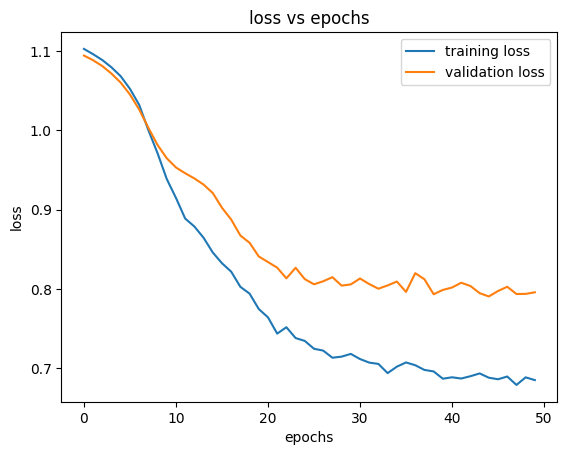

In [40]:
plot_graph(history,'loss')

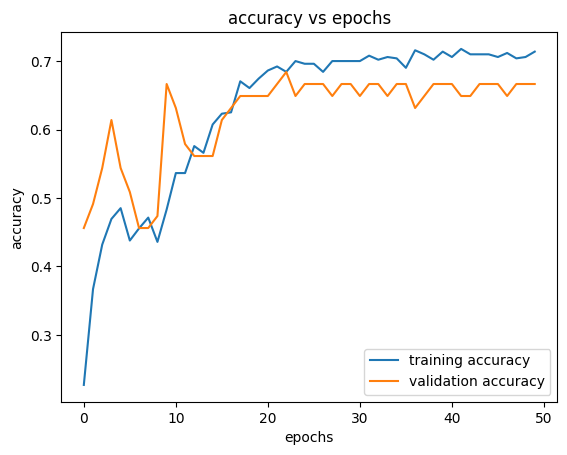

In [41]:
plot_graph(history,'accuracy')

In [42]:
lstm_model.save("new_model.h5")

#test

In [4]:
!pip install tensorflow-addons==0.18.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/test.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/test.zip
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/.DS_Store          
  inflating: __MACOSX/test/._.DS_Store  
   creating: test/sub03/
   creating: test/sub05/
   creating: test/sub02/
   creating: test/sub01/
  inflating: test/sub03/Vd01_Sg_108_VS_Set1.csv  
  inflating: __MACOSX/test/sub03/._Vd01_Sg_108_VS_Set1.csv  
  inflating: test/sub03/Vd01_Sg_082_VS_Set1.csv  
  inflating: __MACOSX/test/sub03/._Vd01_Sg_082_VS_Set1.csv  
  inflating: test/sub03/Vd01_Sg_087_VS_Set1.csv  
  inflating: __MACOSX/test/sub03/._Vd01_Sg_087_VS_Set1.csv  
  inflating: test/sub03/.DS_Store    
  inflating: __MACOSX/test/sub03/._.DS_Store  
  inflating: test/sub03/Vd01_Sg_016_VS_Set1.csv  
  inflating: __MACOSX/test/sub03/._Vd01_Sg_016_VS_Set1.csv  
  inflating: test/sub03/Vd01_Sg_048_VS_Set1.csv  
  inflating: __MACOSX/test/sub03/._Vd01_Sg_048_VS_Set1.csv  
  inflating: test/sub03/Vd01_Sg_073_VS_Set1.csv  
  infl

In [5]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense,Dropout,InputLayer,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import RNN

def prepre_data(x_data,y_data,time_step=31):
    indcies_num = int(x_data.shape[0]  / time_step) 
    x_numpy = np.zeros((indcies_num,time_step,x_data.shape[1]))
    y_numpy = np.zeros((indcies_num,1))
    
    for idx in range(0,indcies_num):
        x_numpy[idx] = x_data.iloc[idx* time_step :(idx+1)*time_step]
        y_numpy[idx] = y_data.iloc[(idx*time_step)+1] 
    return x_numpy,y_numpy


def test_model(path):
  files = glob.glob(f"{path}/*/*.csv")
  data = pd.concat([pd.read_csv(file,header=None) for file in files])
  data = data.reset_index()
  data = data.loc[:,1:]
  data.columns = ["input1","input2","input3","target"]
  data = data[data['target'] != "#"]
  data['input3'] = data['input3'].replace('--1',-1)
  X = data.iloc[:,:3]
  Y = data.iloc[:,3:]
  # scaler = MinMaxScaler()
  # X_scaled = scaler.fit_transform(X)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
  x_train,y_train = prepre_data(X_scaled,Y)
  lstm_model=tf.keras.models.load_model("new_model.h5")
  # predictions = model.predict(x_train)
  # outputs = np.argmax(predictions,axis=1)
  accu=lstm_model.evaluate(x_train,y_train)
  print(accu)
  return y_train



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [6]:
y_train  = test_model('/content/test')


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4/4 [==============================] - 9s 46ms/step - loss: 0.7784 - accuracy: 0.6373
[0.7783839106559753, 0.6372548937797546]
